In [1]:
import sys, os
import pandas as pd
import numpy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
B = [2, 5, 10, 50, 100, 200]

In [3]:
def get_binned_data(bin_value):
    df = pd.read_csv('dating.csv')
    discrete_columns = ['gender', 'race', 'race_o', 'samerace', 'field', 'decision']
    all_columns = df.columns.values.tolist()
    continuous_valued_columns = [item for item in all_columns if item not in discrete_columns]
    
    (row, col) = df.shape
    age_range = [18.0, 58.0]
    pref_score = [0.0, 1.0]
    score = [0.0, 10.0]
    corr_range = [-1.00, 1.00]
    
    bin_seg = [1.000 * i/bin_value for i in range(0, bin_value + 1)]
    #print bin_seg

    age = ['age', 'age_o']
    corr = ['interests_correlate']
    preference_scores_of_participant = \
    ['attractive_important', 'sincere_important', 'intelligence_important',\
     'funny_important', 'ambition_important', 'shared_interests_important']
    
    preference_scores_of_partner = \
    ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', \
     'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']
    
    continuous_valued_columns_bins = {}
    
    # Segment the bins
    for field in continuous_valued_columns:
        continuous_valued_columns_bins[field] = []
        if field in age:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(age_range[0] + bin_seg[i] * (age_range[1] - age_range[0]))
        elif field in corr:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(corr_range[0] + bin_seg[i] * (corr_range[1] - corr_range[0]))
        elif field in preference_scores_of_participant or field in preference_scores_of_partner:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(pref_score[0] + bin_seg[i] * (pref_score[1] - pref_score[0]))
        else:
            for i in range(0, bin_value):
                continuous_valued_columns_bins[field].append(score[0] + bin_seg[i] * (score[1] - score[0]))
    
    # Dictionary of the numbers ine ach bin
    continuous_valued_columns_seg = {}
    # Initalize the dict
    for field in continuous_valued_columns:
        continuous_valued_columns_seg[field] = [0 for i in range(bin_value)]
    
    for i in range(row):
        for field in continuous_valued_columns:
            # Find the bin
            for j in range(0, bin_value):
                # Corner Case
                if j == 0:
                    if continuous_valued_columns_bins[field][j] <= float(df[field][i]) <= continuous_valued_columns_bins[field][j + 1]:
                        df.loc[i,field] = int(j)
                        continuous_valued_columns_seg[field][j] += 1
                        break
                elif j == bin_value - 1:
                    if continuous_valued_columns_bins[field][j] < float(df[field][i]):
                        df.loc[i,field] = int(j)
                        continuous_valued_columns_seg[field][j] += 1
                        break
                else:
                    if continuous_valued_columns_bins[field][j] < float(df[field][i]) <= continuous_valued_columns_bins[field][j + 1]:
                        df.loc[i,field] = int(j)
                        continuous_valued_columns_seg[field][j] += 1
                        break
        
    df = df.astype('int64')
    df_test = df.sample(frac=0.2, random_state=47)
    #df_test.to_csv('testSet.csv', index=False)
    
    # Subtract 
    df_train = df[~df.index.isin(df_test.index)]
    #df_train.to_csv('trainingSet.csv', index=False)

    return df_train, df_test

In [4]:
def nbc(t_frac, df_train, df_test, bin_N):
    attr_list = list(df_train[df_train.columns.difference(['decision'])])
    dict_table ={}

    # Labels
    dict_labels = {}
    dict_labels['no'] = len(df_train[df_train['decision'] == 0])
    dict_labels['yes'] = len(df_train[df_train['decision'] == 1])
    dict_table['decision'] = dict_labels
    
    # Attributes in discrete_columns
    for attr in attr_list:
        dict_attr = {}
        attr_bin = max(df_train[attr].max(), df_test[attr].max())
        #print attr_bin
        dict_attr['no'] = [0 for i in range(attr_bin + 1)]
        dict_attr['yes'] = [0 for i in range(attr_bin + 1)]
        
        for i in range(attr_bin + 1):
            dict_attr['no'][i] += len(df_train[(df_train[attr] == i) & (df_train['decision'] == 0)])
            dict_attr['yes'][i] += len(df_train[(df_train[attr] == i) & (df_train['decision'] == 1)])

        dict_table[attr] = dict_attr
        
    return dict_table

In [5]:
A_train = []
A_test = []

for bin_N in B:
    print 'Bin size:', bin_N    
    
    df_train, df_test = get_binned_data(bin_N)
    
    dict_table = nbc(1, df_train, df_test, bin_N)
    #print dict_table
    # Accuracy on training data
    (row, col) = df_train.shape
    #print df_train.shape
    #print df_train
    attr_list = list(df_train[df_train.columns.difference(['decision'])])
    
    row_index = df_train.index.tolist()

    # Train
    neg_num = len(df_train[df_train['decision'] == 0])
    pos_num = len(df_train[df_train['decision'] == 1])
    correct = 0
    
    for i in row_index:
        pd_pos = 1.0 * dict_table['decision']['yes']/row
        pd_neg = 1.0 * dict_table['decision']['no']/row
        for attr in attr_list:
            #print attr, i
            pd_pos *= 1.0 * dict_table[attr]['yes'][int(df_train[attr][i])]/pos_num
            pd_neg *= 1.0 * dict_table[attr]['no'][int(df_train[attr][i])]/neg_num
        
        res = np.argmax([1.0 * pd_neg, 1.0 * pd_pos])
        if res == df_train['decision'][i]:
            correct += 1
    #print correct
    training_accuracy = 1.0 * correct/row
    print 'Training Accuracy:', '%.2f' % training_accuracy
    A_train.append(training_accuracy)
    
    # Test
    row_index_test = df_test.index.tolist()
    (row, col) = df_test.shape
    correct = 0
    for i in row_index_test:
        pd_pos = 1.0 * dict_table['decision']['yes']/row
        pd_neg = 1.0 * dict_table['decision']['no']/row
        for attr in attr_list:
            #print attr, i
            pd_pos *= 1.0 * dict_table[attr]['yes'][int(df_test[attr][i])]/pos_num
            pd_neg *= 1.0 * dict_table[attr]['no'][int(df_test[attr][i])]/neg_num
        
        res = np.argmax([1.0 * pd_neg, 1.0 * pd_pos])
        if res == df_test['decision'][i]:
            correct += 1
    #print correct
    test_accuracy = 1.0 * correct/row
    print 'Test Accuracy:', '%.2f' % test_accuracy
    A_test.append(test_accuracy)

Bin size: 2
Training Accuracy: 0.76
Test Accuracy: 0.72
Bin size: 5
Training Accuracy: 0.78
Test Accuracy: 0.75
Bin size: 10
Training Accuracy: 0.79
Test Accuracy: 0.75
Bin size: 50
Training Accuracy: 0.80
Test Accuracy: 0.75
Bin size: 100
Training Accuracy: 0.80
Test Accuracy: 0.76
Bin size: 200
Training Accuracy: 0.81
Test Accuracy: 0.75


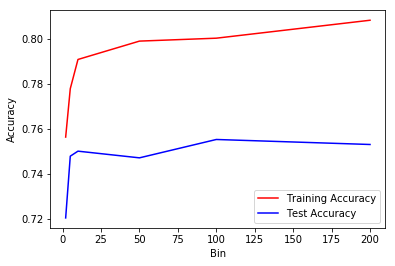

In [6]:
fig = plt.figure()
plt.plot(B, A_train, color='red', label='Training Accuracy')
plt.plot(B, A_test, color='blue', label='Test Accuracy')

plt.xlabel("Bin")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig('./figs/5_2.png')
#plt.show()